## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole, joule, meter, pascals, kilojoule
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_468618/2833670413.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*            

## Loading data and creating atom group of ions

In [2]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname SOD CLA')

u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname SOD CLA')

u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname SOD CLA')

u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname SOD CLA')

box_size = u.dimensions[:3] * angstrom
print(box_size)
half_box=box_size[2]/2
print(half_box)


[ 48.  48. 144.] A
72.0 A


In [3]:
k= 1.0457*(kilojoule_per_mole/nanometer**2)
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant
vanthoff_nu=2
temp=300*kelvin

In [4]:
# def osmotic_ideal(molarity, vant_hoff:int=2, T=300*kelvin):
#     osm_press_ideal=vant_hoff*molarity*R*T
#     osm_press_ideal=osm_press_ideal.in_units_of(bar)
#     print(f"Osmotic Pressure Ideal:", osm_press_ideal)
#     return osm_press_ideal

# oi1=osmotic_ideal(0.976*(mole/litre),2,300*kelvin)
# oi2=osmotic_ideal(1.923*(mole/litre),2,300*kelvin)
# oi3=osmotic_ideal(2.823*(mole/litre),2,300*kelvin)

def osm_experimental(exp_osm_coeff, molarity:Quantity=1*(mole/litre), vant_hoff=vanthoff_nu, T=temp):
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_bar=exp_osm_coeff*osm_press_ideal
    op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
    print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentraion {molarity}')
    print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    return osm_bar


In [21]:
# xz,yz = np.loadtxt("density_hwr1.xvg",comments=["@", "#"],unpack=True)
# ## Assign units to number density values and convert them to concentration units mol/L 
# yz=(yz/nanometer**3)/(AVOGADRO_CONSTANT_NA)
# yz=yz.in_units_of(mole/litre)/2

# halfz=int((len(yz)/2)-1)
# print(yz[halfz])
# ## Average concentration from both sides of the middle of the box (7.2 nm) 
# yz1=yz[:halfz+1]
# print(yz1)
# yz2=yz[halfz:-1]
# yz2=yz2[::-1]
# yz1 = np.array(yz1)
# yz2 = np.array(yz2)
# av_y=[(a+b)/2 for a,b in zip(yz1,yz2)]
# av_C=av_y[::-1]
# av_C=np.array(av_C)*(mole/litre)
# xz2=np.array(xz[:halfz+1])*nanometer
# print(av_C,len(av_C))

In [22]:
##Function to symmetrize to the median of the density plot
def conc_prof_hw(filename):
    xz,yz = np.loadtxt(filename,comments=["@", "#"],unpack=True)
    ## Assign units to number density values and convert them to concentration units mol/L 
    yz=(yz/nanometer**3)/(AVOGADRO_CONSTANT_NA)
    yz=yz.in_units_of(mole/litre)/2
    halfz=int((len(yz)/2)-1)
    ## Average concentration from both sides of the middle of the box (7.2 nm) 
    yz1=yz[:halfz+1]
    yz2=yz[halfz:-1]
    yz2=yz2[::-1]
    yz1 = np.array(yz1)
    yz2 = np.array(yz2)
    av_y=[(a+b)/2 for a,b in zip(yz1,yz2)]
    av_C=av_y[::-1]
    av_C=np.array(av_C)*(mole/litre)
    xz2=np.array(xz[:halfz+1])*nanometer
    return xz2, av_C

## Function to calculate Osmotic Pressure
def calculate_pi(z_coordinates,z_concentrations,pi_1:Quantity,springk,vanthoff=vanthoff_nu):
    
    z_coordinates=z_coordinates[::-1]
    z_concentrations=z_concentrations[::-1]
    delta_z=z_coordinates[0]-z_coordinates[1]
    pi_results = []

    ## Calculate Pi_2 stepwise
    for i in range(len(z_concentrations)-1):
        #print(pi_1)
        
        ## Calculate the average of concentration
        phi_avg = (z_concentrations[i+1] + z_concentrations[i]) / 2
        #print(phi_avg)
        
        ## Calculate the average of z coordinates
        z_avg = (z_coordinates[i+1] + z_coordinates[i]) / 2
        #print(z_avg)
        
        ## Calculate Pi_2
        fact1=vanthoff*phi_avg*z_avg*springk*delta_z
        fact2=(fact1.in_units_of(joule/meter**3)).in_units_of(pascals)
        mult_fact=fact2.in_units_of(bar)
        pi_2 = pi_1 + mult_fact
        pi_results.append(pi_2._value)

        ## Set pi_2 as the new pi_1 for next iteration
        pi_1=pi_2


    # #print(f'phi_avg final = {phi_avg}, z_avg final = {z_avg}, fact1 = {fact1}, pi_2 = {pi_2}')
    return z_concentrations, pi_results

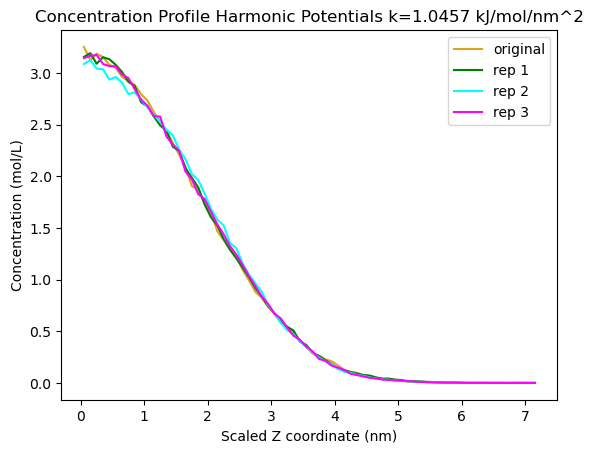

In [23]:
original_x, original_y = conc_prof_hw("density_hwl.xvg")
r1_x, r1_y = conc_prof_hw("density_hwr1.xvg")
r2_x, r2_y = conc_prof_hw("density_hwr2.xvg")
r3_x, r3_y = conc_prof_hw("density_hwr3.xvg")

##Plot concentration gradient
plt.plot(original_x, original_y, c='goldenrod', label='original')
plt.plot(r1_x, r1_y, c='green', label='rep 1')
plt.plot(r2_x, r2_y, c='cyan', label='rep 2')
plt.plot(r3_x, r3_y, c='magenta', label='rep 3')
plt.xlabel("Scaled Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 7.2, 1.0))
plt.yticks(np.arange(0, 3.5, 0.5))
plt.title('Concentration Profile Harmonic Potentials k=1.0457 kJ/mol/nm^2')
plt.legend()
plt.show()

## Fittings

In [ ]:
# import scipy as sp
# from scipy.interpolate import interp1d

# x = original_x
# y = original_y

# coeffs = np.polyfit(x, y, deg=6)#you can change degree as you see fit
# poly = np.poly1d(coeffs)
# yp = np.polyval(poly, x)

# interpLength = 72
# new_x = np.linspace(x.min(), x.max(), interpLength)
# new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)


# plt.plot(x, y, '.', x, yp, '-', new_x,new_y, '--')
# plt.show()

In [29]:
print(original_y)

[3.25403387e+00 3.12707736e+00 3.18929360e+00 3.15584619e+00
 3.08104306e+00 3.05155189e+00 2.96343953e+00 2.92423836e+00
 2.88683887e+00 2.79620664e+00 2.73578793e+00 2.62393817e+00
 2.53115140e+00 2.44159853e+00 2.32435616e+00 2.20747497e+00
 2.09238716e+00 1.90429790e+00 1.87804478e+00 1.73706501e+00
 1.65218656e+00 1.46877171e+00 1.38389741e+00 1.29506687e+00
 1.22241829e+00 1.09294606e+00 9.91889801e-01 8.81839650e-01
 8.23935407e-01 7.35466037e-01 6.66414596e-01 5.83696918e-01
 5.40540338e-01 4.88751445e-01 4.15744600e-01 3.54246120e-01
 2.84835587e-01 2.64335817e-01 2.28731369e-01 2.09670456e-01
 1.69031253e-01 1.28032129e-01 1.07532442e-01 9.78223564e-02
 7.69632044e-02 6.76124598e-02 5.50250340e-02 3.59640381e-02
 3.63237109e-02 2.12187833e-02 1.94206271e-02 1.36663611e-02
 1.51049276e-02 1.33067298e-02 4.67533077e-03 6.11390143e-03
 3.23676426e-03 2.15784270e-03 1.43856651e-03 1.43856360e-03
 7.19283254e-04 3.59640797e-04 1.07892280e-03 7.19281593e-04
 7.19281593e-04 7.192832

In [30]:
wht=original_y[0]
wht=wht.value_in_unit(wht.unit)
print(wht)

3.254033869510549


In [31]:
#coefficients along a line of constant chemical potential of the water
A_M=1.7964*(mole/litre)**(-1/2)
B_M=1.9247*(mole/litre)**(-1/2)
a1_M=9.3393E-2*(mole/litre)**(-1)
a2_M=3.4572E-2*(mole/litre)**(-2)

In [ ]:
#coefficients along a line of constant pressure
# A_m=1.7937*(mole/litre)**(-1/2)
# B_m=1.9247*(mole/litre)**(-1/2)
# a1_m=9.3393E-2*(mole/litre)**(-1)
# a2_m=3.4572E-2*(mole/litre)**(-2)

In [50]:
def fitting_lstsq(y_data,alphai,imax=2):
    c_s=y_data.value_in_unit(y_data.unit)
    sqrt_cs=np.sqrt(c_s)
    c_max=c_s[0]
    sqrt_cmax=np.sqrt(c_max)
    A_fit=A_M.value_in_unit(A_M.unit)
    B_fit=B_M.value_in_unit(B_M.unit)
    with np.errstate(divide='ignore', invalid='ignore'):
        term1 = np.true_divide(c_s,c_max)
        term1[term1 == np.inf] = 0
        term1 = np.nan_to_num(term1)

    t2_denom1=np.add(1,(np.multiply(B_fit,sqrt_cmax)))
    t2_frac1=np.divide(sqrt_cmax,t2_denom1)
    t2_denom2=np.add(1,(np.multiply(B_fit,sqrt_cs)))
    t2_frac2=np.divide(sqrt_cs,t2_denom2)
    t2_inside=t2_frac1-t2_frac2
    term2=A_fit*t2_inside

    results=[]
    for i in range(imax):
        t3_inside=c_s**i-c_max**i
        term3=np.multiply(alphai,t3_inside)
        objective=np.add(term1,term2,term3)
        results.append(objective)
    return results

print(fitting_lstsq(original_y,a1_M))

[array([1.0, 0.9642269035038474, 0.9817372962133906, 0.9723186999631782,
       0.951297295880327, 0.943026360126162, 0.918373988309581,
       0.9074357486951862, 0.8970179254342008, 0.8718466286709493,
       0.8551282807043251, 0.8243183164252788, 0.7989075058106869,
       0.7745206872444256, 0.7428178280882853, 0.7114921160408617,
       0.6809518598892085, 0.6317907541465019, 0.6250122113011445,
       0.5890098865774893, 0.5676927937463249, 0.522723573894763,
       0.5025092705382835, 0.4818315395045014, 0.4653345700071805,
       0.4370220490689542, 0.4160879015454654, 0.3947446477314851,
       0.38425342996493445, 0.36942991299566624, 0.3590827482220075,
       0.3484650998368093, 0.3438697762266053, 0.33940473441428115,
       0.33553456319342306, 0.335165306510528, 0.3392292014001229,
       0.3416431079944388, 0.3475689866913762, 0.3518346392478156,
       0.36427334409745704, 0.38333740728817217, 0.3965337949079275,
       0.4039688523888973, 0.4233954570584991, 0.434101

## Calculating osmotic values

In [ ]:
## Calculate ideal osmotic pressure at max concentration to have an idea of what the value should be close to  
def osmotic_values(molality, conc_vals, osmpress_vals,repnum):
    vant_hoff=2
    T=300*kelvin

    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    if molality == 1:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-0.976*(mole/litre)))
        print(f'Osmotic values for ~1m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar
    
    if molality == 2:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-1.923*(mole/litre)))
        print(f'Osmotic values for ~2m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar
    
    if molality == 3:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-2.823*(mole/litre)))
        print(f'Osmotic values for ~3m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar

    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    print(f"Osmotic Pressure Ideal: {osm_press_ideal}")

    osm_coeff=osm_press_obs/osm_press_ideal

    print(f"Osmotic Pressure Observed: {osm_press_obs}, Osmotic Coefficient: {osm_coeff} \n")

    tresults = dict()

    tresults['os_pres_val'] = osm_press_obs
    tresults['os_coef_val'] = osm_coeff
    tresults['m'] = molality
    tresults['repnum'] = repnum
    
    return tresults



#### (exp_osm_coeff=0.936,molarity=0.976*(mole/litre))
#### (exp_osm_coeff=0.984,molarity=1.923*(mole/litre))
#### (exp_osm_coeff=1.045,molarity=2.823*(mole/litre))

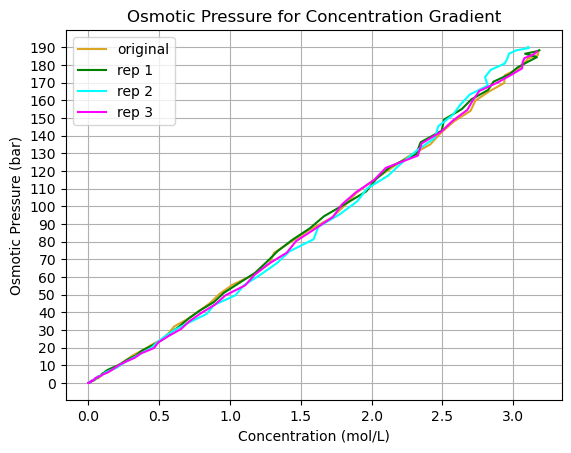

In [ ]:
z_concs_o, pi_val_o = calculate_pi(original_x, original_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r1, pi_val_r1 = calculate_pi(r1_x, r1_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r2, pi_val_r2 = calculate_pi(r2_x, r2_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r3, pi_val_r3 = calculate_pi(r3_x, r3_y, pi_1=0*bar, springk=k,vanthoff=2)


plt.plot(z_concs_o[1:], pi_val_o, c='goldenrod', label='original')
plt.plot(z_concs_r1[1:], pi_val_r1, c='green', label='rep 1')
plt.plot(z_concs_r2[1:], pi_val_r2, c='cyan', label='rep 2')
plt.plot(z_concs_r3[1:], pi_val_r3, c='magenta', label='rep 3')
plt.xlabel("Concentration (mol/L)")
plt.ylabel("Osmotic Pressure (bar)")
plt.xticks(np.arange(0, 3.5, 0.5))
plt.yticks(np.arange(0, 200, 10))
plt.title('Osmotic Pressure for Concentration Gradient')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from scipy.optimize import curve_fit
##linear function to fit
def linearFunc(x,intercept,slope):
    y = intercept + slope * x
    return y


In [ ]:
molal_conc=[1,2,3]
z_conc_vals=[z_concs_o,z_concs_r1,z_concs_r2,z_concs_r3]
pi_vals=[pi_val_o,pi_val_r1,pi_val_r2,pi_val_r3]
repnum=[0,1,2,3]

presults1m=list()
presults2m=list()
presults3m=list()


# for m in molal_conc:
for (czi,opi,rn) in zip(z_conc_vals,pi_vals,repnum):
    print(rn)
    presults1m.append(osmotic_values(1,czi,opi,rn))
    presults2m.append(osmotic_values(2,czi,opi,rn))
    presults3m.append(osmotic_values(3,czi,opi,rn))



0
Data for original run
Osmotic values for ~1m, molar concentration = 1.0185040908940826 mol/L
Osmotic Pressure Ideal: 50.80988514104999 bar
Osmotic Pressure Observed: 55.647445471695846 bar, Osmotic Coefficient: 1.0952090388950226 

Data for original run
Osmotic values for ~2m, molar concentration = 1.8902746471173482 mol/L
Osmotic Pressure Ideal: 94.29970734899999 bar
Osmotic Pressure Observed: 107.45840854788965 bar, Osmotic Coefficient: 1.1395412729139205 

Data for original run
Osmotic values for ~3m, molar concentration = 2.8300152187077074 mol/L
Osmotic Pressure Ideal: 141.18033446849998 bar
Osmotic Pressure Observed: 165.05361357623437 bar, Osmotic Coefficient: 1.1690977656173565 

1
Data for replicate # 1
Osmotic values for ~1m, molar concentration = 0.9555655089005259 mol/L
Osmotic Pressure Ideal: 47.6700822177 bar
Osmotic Pressure Observed: 50.96752163593765 bar, Osmotic Coefficient: 1.069172094211604 

Data for replicate # 1
Osmotic values for ~2m, molar concentration = 1.9

In [ ]:
def get_osm_vals(results):
    op_vals = list()
    oc_vals = list()
    concs = list()

    for r in results:
        v = r['os_pres_val']
        op_vals.append(v.value_in_unit(v.unit))
        oc_vals.append(r['os_coef_val'])
        concs.append(r['m'])
        
    oc_vals = np.array(oc_vals)
    op_vals = np.array(op_vals)
    concs = np.array(concs)
    
    print('Concentration =', concs)
    print('op replicates')
    print(op_vals)
    print('oc replicates')
    print(oc_vals)

 
    stdop = op_vals.std(ddof=1)
    print(f'std of osmotic presssure: {stdop:.3f}')
    stdoc = oc_vals.std(ddof=1)
    print(f'std of osmotic coeff: {stdoc:.3f}')

    print("mean of op replicates: ",end="")
    print(f'osmotic pressure {op_vals.mean():.3f} +/- {stdop/np.sqrt(len(op_vals)):.3f}')
    print("mean of oc replicates: ",end="")
    print(f'osmotic coeff {oc_vals.mean():.3f} +/- {stdoc/np.sqrt(len(oc_vals)):.3f}')

    final_results = dict()

    final_results['conc'] = concs[0]
    final_results['stdev_op'] = stdop
    final_results['stdev_oc'] = stdoc
    final_results['mean_op'] = op_vals.mean()
    final_results['mean_oc'] = oc_vals.mean()
    final_results['op_errs'] = stdop/np.sqrt(len(op_vals))
    final_results['oc_errs'] = stdoc/np.sqrt(len(oc_vals))

    return final_results


In [ ]:
fres1m=get_osm_vals(presults1m)
fres2m=get_osm_vals(presults2m)
fres3m=get_osm_vals(presults3m)

Concentration = [1 1 1 1]
op replicates
[55.64744547 50.96752164 49.56737973 49.60330411]
oc replicates
[1.09520904 1.06917209 0.95828964 1.02778844]
std of osmotic presssure: 2.876
std of osmotic coeff: 0.060
mean of op replicates: osmotic pressure 51.446 +/- 1.438
mean of oc replicates: osmotic coeff 1.038 +/- 0.030
Concentration = [2 2 2 2]
op replicates
[107.45840855 108.40855594 102.82901144 107.95442213]
oc replicates
[1.13954127 1.10788468 1.0859058  1.1454553 ]
std of osmotic presssure: 2.585
std of osmotic coeff: 0.028
mean of op replicates: osmotic pressure 106.663 +/- 1.293
mean of oc replicates: osmotic coeff 1.120 +/- 0.014
Concentration = [3 3 3 3]
op replicates
[165.05361358 165.85154285 168.45251906 165.35041702]
oc replicates
[1.16909777 1.17804331 1.19712911 1.20049257]
std of osmotic presssure: 1.552
std of osmotic coeff: 0.015
mean of op replicates: osmotic pressure 166.177 +/- 0.776
mean of oc replicates: osmotic coeff 1.186 +/- 0.008


## Osmotic Pressure Plot for 1,2,3 m

In [ ]:
expOC_1m=0.936
expOC_2m=0.984
expOC_3m=1.045

yexpOC=[expOC_1m,expOC_2m,expOC_3m]

expOP_1m=osm_experimental(exp_osm_coeff=0.936,molarity=0.976*(mole/litre))
expOP_2m=osm_experimental(exp_osm_coeff=0.984,molarity=1.923*(mole/litre))
expOP_3m=osm_experimental(exp_osm_coeff=1.045,molarity=2.823*(mole/litre))

yexpOP=[expOP_1m._value,expOP_2m._value,expOP_3m._value]

Ideal Osmotic Pressure: 48.68949309190537 bar at concentraion 0.976 mol/L
Osmotic Pressure from experimental osmotic coefficient: 45.57336553402343 bar
Ideal Osmotic Pressure: 95.93226968825209 bar at concentraion 1.923 mol/L
Osmotic Pressure from experimental osmotic coefficient: 94.39735337324005 bar
Ideal Osmotic Pressure: 140.83036782627957 bar at concentraion 2.823 mol/L
Osmotic Pressure from experimental osmotic coefficient: 147.16773437846214 bar


In [ ]:
xconc=[fres1m['conc'],fres2m['conc'],fres3m['conc']]

yHP_OP=[fres1m['mean_op'],fres2m['mean_op'],fres3m['mean_op']]
yHP_OPerr=[fres1m['op_errs'],fres2m['op_errs'],fres3m['op_errs']]
print(yHP_OP)
print(yHP_OPerr)

yHP_OC=[fres1m['mean_oc'],fres2m['mean_oc'],fres3m['mean_oc']]
yHP_OCerr=[fres1m['oc_errs'],fres2m['oc_errs'],fres3m['oc_errs']]
print(yHP_OC)
print(yHP_OCerr)

[51.446412736156844, 106.66259951381392, 166.17702312724953]
[1.4377594603017534, 1.2925065778196625, 0.7761628817232513]
[1.0376148047327565, 1.1196967644642293, 1.1861906894913834]
[0.029863574195319736, 0.013960244211639883, 0.007542880721910575]


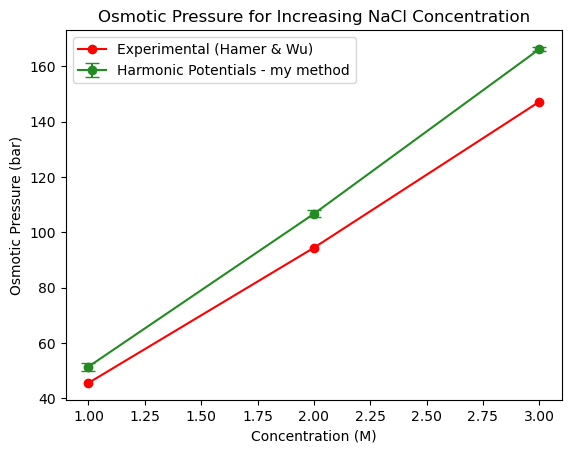

In [ ]:

plt.errorbar(xconc,yHP_OP, yerr=yHP_OPerr, fmt='o', linestyle='-',color='forestgreen', capsize=5, label='Harmonic Potentials - my method')

plt.plot(xconc,yexpOP, marker='o', linestyle='-',color='red', label='Experimental (Hamer & Wu)')

plt.xlabel("Concentration (M)")
plt.ylabel("Osmotic Pressure (bar)")
# plt.title('Osmotic Pressure for Increasing NaCl Concentration')
plt.title('Osmotic Pressure for Increasing NaCl Concentration')
plt.legend()
plt.show()

### Density profiles using GROMACS

In [ ]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y=y.in_units_of(mole/litre)/2
x1,y1 = np.loadtxt("dens_r1.xvg",comments=["@", "#"],unpack=True)
y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y1=y1.in_units_of(mole/litre)/2
x2,y2 = np.loadtxt("dens_r2.xvg",comments=["@", "#"],unpack=True)
y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y2=y2.in_units_of(mole/litre)/2
x3,y3 = np.loadtxt("dens_r3.xvg",comments=["@", "#"],unpack=True)
y3=(y3/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y3=y3.in_units_of(mole/litre)/2
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(x,y, c='purple', label='original')
plt.plot(x1,y1, c='g', label='rep 1')
plt.plot(x2,y2, c='c', label='rep 2')
plt.plot(x3,y3, c='m', label='rep 3')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Concentration profile - CHARMM27')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

FileNotFoundError: density_original.xvg not found.

## Density profiles using MDanalysis

In [ ]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [ ]:
# nbins,ncounts=density_profile(u,ions,2)
# nbins1,ncounts1=density_profile(u1,ions1,2)
# nbins2,ncounts2=density_profile(u2,ions2,2)
# nbins3,ncounts3=density_profile(u3,ions3,2)

### Density plots

In [ ]:
nb=144.4/72
volbin=48*48*nb*angstrom**3
counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts1=(ncounts1/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

bins=nbins/10
bins1=nbins1/10
bins2=nbins2/10
bins3=nbins3/10

print(counts)

plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(bins[1:],counts, c='orange', label='original')
plt.plot(bins1[1:],counts1, c='g', label='rep1')
plt.plot(bins2[1:],counts2, c='c', label='rep2')
plt.plot(bins3[1:],counts3, c='m', label='rep3')

plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1))
plt.title("Concentration profile of replicates - CHARMM27")
plt.legend()
plt.show()

NameError: name 'ncounts' is not defined